In [25]:
# This is a Jupyter notebook - cells are executed sequentially
# Variables and imports from previous cells are available in later cells
# Pylance may show false warnings about undefined variables/imports across cells

# Interactive Machine Learning Model Training for Real Estate sale Pricing

This notebook provides an interactive environment to train and evaluate multiple regression models for real estate sale price prediction.

## 1. Import Required Libraries

In [26]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore Data

In [ ]:
# Load sale data
data_path = Path("data") / "sale_processed.csv"
df = pd.read_csv(data_path)

print(f"Sale Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())

Sale Dataset shape: (12901, 18)

First few rows:
              region      price  price_normalized  surface  rooms  bathrooms  \
0             Mornag   750000.0          0.202561    527.0      5          5   
1  Boumhel Bassatine  1690000.0          1.920106    550.0      6          6   
2            Le Kram   682500.0          0.079227    161.0      3          3   
3           La Marsa   682500.0          0.079227    224.0      4          3   
4    Nouvelle Medina   180000.0         -0.838928     61.0      1          1   

  property_type  property_type_cluster price_segment  has_piscine  has_garage  \
0         Villa                      1        Medium        False        True   
1         Villa                      1          High        False        True   
2   Appartement                      0          High         True       False   
3   Appartement                      0          High        False       False   
4   Appartement                      2           Low         True

## 3. Prepare Features and Target

In [28]:
# Define target and features
target_col = "price_normalized"

X = df.drop(columns=[target_col, 'price','property_type_cluster'])
y = df[target_col]

# Identify categorical and numeric columns
numeric_cols = ['surface', 'rooms', 'bathrooms']
categorical_cols = ['region', 'property_type','city', 'price_segment', 'has_piscine', 'has_garage', 'has_jardin', 'has_terrasse', 'has_ascenseur', 'is_meuble', 'has_chauffage', 'has_climatisation']

print(f"Target column: {target_col}")
print(f"Number of features: {X.shape[1]}")
print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")


Target column: price_normalized
Number of features: 15

Numeric columns (3): ['surface', 'rooms', 'bathrooms']

Categorical columns (12): ['region', 'property_type', 'city', 'price_segment', 'has_piscine', 'has_garage', 'has_jardin', 'has_terrasse', 'has_ascenseur', 'is_meuble', 'has_chauffage', 'has_climatisation']


## 4. Define Preprocessing Pipeline

In [29]:
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

print("✓ Preprocessing pipeline created")

✓ Preprocessing pipeline created


## 5. Split Data into Train and Test Sets

In [30]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0] / len(X) * 100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0] / len(X) * 100:.1f}%)")

Training set size: 10320 samples (80.0%)
Test set size: 2581 samples (20.0%)


## 6. Initialize and Train Models

In [31]:
# Define models
models = {
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42),
}

# Try to add optional models
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    print("✓ XGBoost added")
except Exception as exc:
    print(f"⚠ XGBoost not available: {exc}")

try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
    )
    print("✓ LightGBM added")
except Exception as exc:
    print(f"⚠ LightGBM not available: {exc}")

print(f"\nTotal models to train: {len(models)}")
print(f"Models: {list(models.keys())}")

✓ XGBoost added
✓ LightGBM added

Total models to train: 5
Models: ['Ridge', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']


In [32]:
# Train models and store results
print("Training models...\n")
trained_pipelines = {}
results = []

for model_name, model in models.items():
    print(f"Training {model_name}...", end=" ")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    trained_pipelines[model_name] = pipeline
    
    print("✓")

print(f"\n✓ All {len(models)} models trained successfully")

Training models...

Training Ridge... ✓
Training RandomForest... ✓
Training GradientBoosting... ✓
Training XGBoost... ✓
Training LightGBM... [LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 10320, number of used features: 122
[LightGBM] [Info] Start training from score -0.035025
✓

✓ All 5 models trained successfully


## 7. Evaluate Model Performance

In [33]:
# Evaluate models
print("Evaluating models on test set...\n")

for model_name, pipeline in trained_pipelines.items():
    # Make predictions
    preds = pipeline.predict(X_test)
    
    # Calculate metrics
    rmse = root_mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append({
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
    })
    
    print(f"{model_name:20} | RMSE: {rmse:12,.2f} | MAE: {mae:12,.2f} | R²: {r2:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results).sort_values("RMSE")
print("\n" + "="*70)
print("Sorted by RMSE (best at top):")
print("="*70)
print(results_df.to_string(index=False))

Evaluating models on test set...

Ridge                | RMSE:         0.60 | MAE:         0.36 | R²: 0.6679
RandomForest         | RMSE:         0.54 | MAE:         0.29 | R²: 0.7251
GradientBoosting     | RMSE:         0.56 | MAE:         0.33 | R²: 0.7086
XGBoost              | RMSE:         0.55 | MAE:         0.31 | R²: 0.7236
LightGBM             | RMSE:         0.55 | MAE:         0.31 | R²: 0.7216

Sorted by RMSE (best at top):
           Model     RMSE      MAE       R²
    RandomForest 0.544130 0.293025 0.725110
         XGBoost 0.545611 0.310520 0.723610
        LightGBM 0.547582 0.309227 0.721610
GradientBoosting 0.560273 0.327337 0.708557
           Ridge 0.598041 0.358120 0.667940


## 8. Compare Results and Visualize Metrics

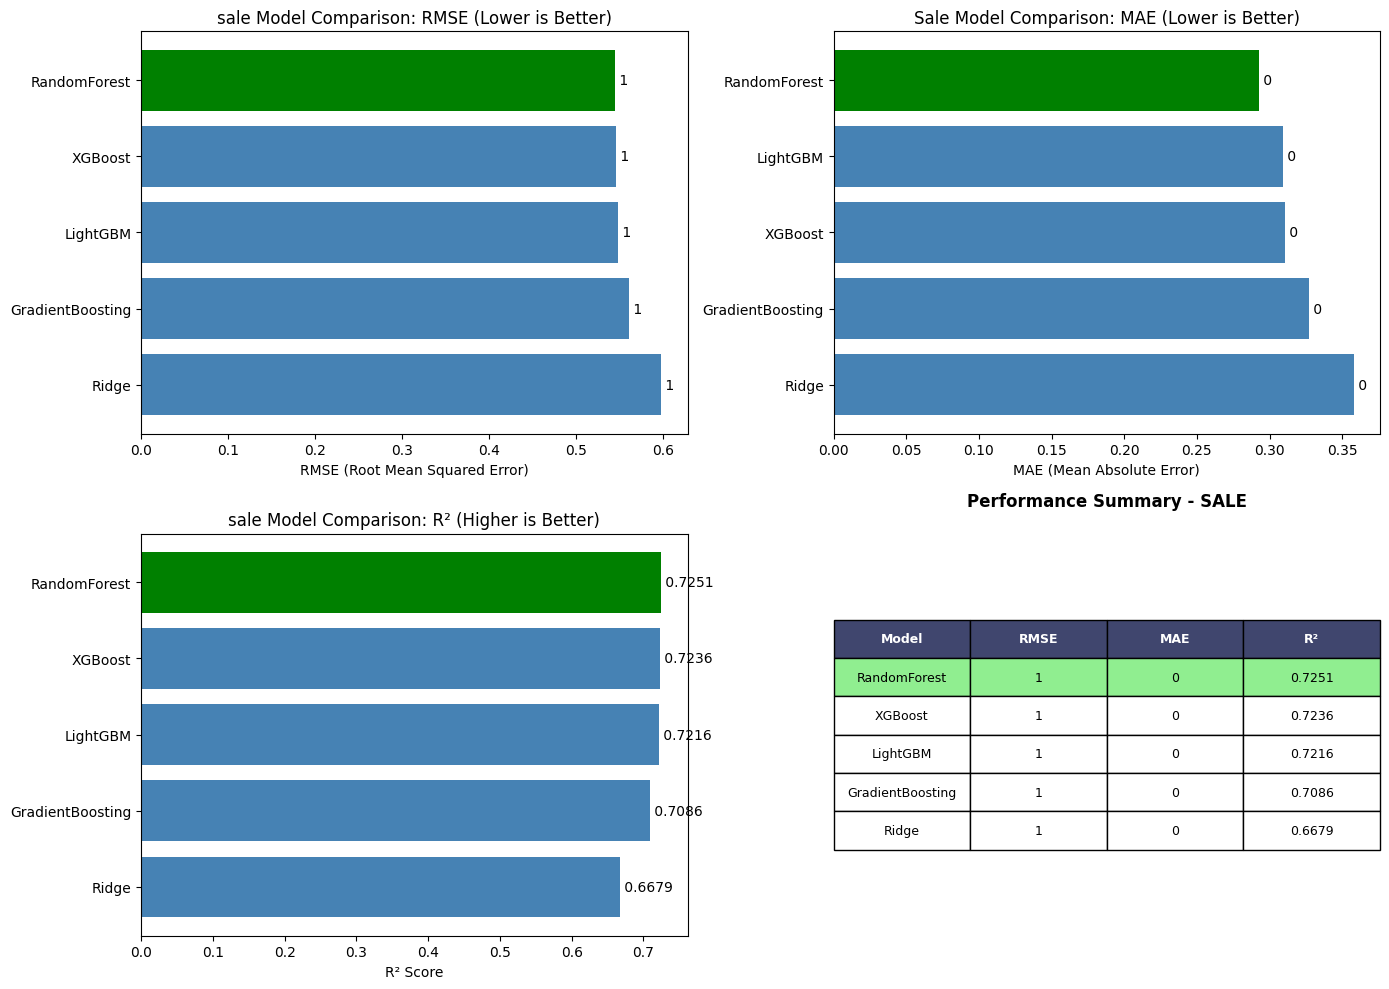

In [34]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sort by RMSE for visualizations
results_sorted = results_df.sort_values("RMSE")

# 1. RMSE Comparison
ax1 = axes[0, 0]
colors = ['green' if i == 0 else 'steelblue' for i in range(len(results_sorted))]
ax1.barh(results_sorted["Model"], results_sorted["RMSE"], color=colors)
ax1.set_xlabel("RMSE (Root Mean Squared Error)")
ax1.set_title("sale Model Comparison: RMSE (Lower is Better)")
ax1.invert_yaxis()
for i, v in enumerate(results_sorted["RMSE"]):
    ax1.text(v, i, f" {v:,.0f}", va='center')

# 2. MAE Comparison
ax2 = axes[0, 1]
results_mae = results_df.sort_values("MAE")
colors = ['green' if results_mae.iloc[i]["Model"] == results_sorted.iloc[0]["Model"] else 'steelblue' 
          for i in range(len(results_mae))]
ax2.barh(results_mae["Model"], results_mae["MAE"], color=colors)
ax2.set_xlabel("MAE (Mean Absolute Error)")
ax2.set_title("Sale Model Comparison: MAE (Lower is Better)")
ax2.invert_yaxis()
for i, v in enumerate(results_mae["MAE"]):
    ax2.text(v, i, f" {v:,.0f}", va='center')

# 3. R² Comparison
ax3 = axes[1, 0]
results_r2 = results_df.sort_values("R²", ascending=False)
colors = ['green' if results_r2.iloc[i]["Model"] == results_sorted.iloc[0]["Model"] else 'steelblue' 
          for i in range(len(results_r2))]
ax3.barh(results_r2["Model"], results_r2["R²"], color=colors)
ax3.set_xlabel("R² Score")
ax3.set_title("sale Model Comparison: R² (Higher is Better)")
ax3.invert_yaxis()
for i, v in enumerate(results_r2["R²"]):
    ax3.text(v, i, f" {v:.4f}", va='center')

# 4. Metrics Summary Table as visualization
ax4 = axes[1, 1]
ax4.axis('off')
table_data = []
for _, row in results_sorted.iterrows():
    table_data.append([
        row["Model"],
        f"{row['RMSE']:,.0f}",
        f"{row['MAE']:,.0f}",
        f"{row['R²']:.4f}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=["Model", "RMSE", "MAE", "R²"],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color header
for i in range(4):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color best model row
for i in range(4):
    table[(1, i)].set_facecolor('#90EE90')

ax4.set_title("Performance Summary - SALE", fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

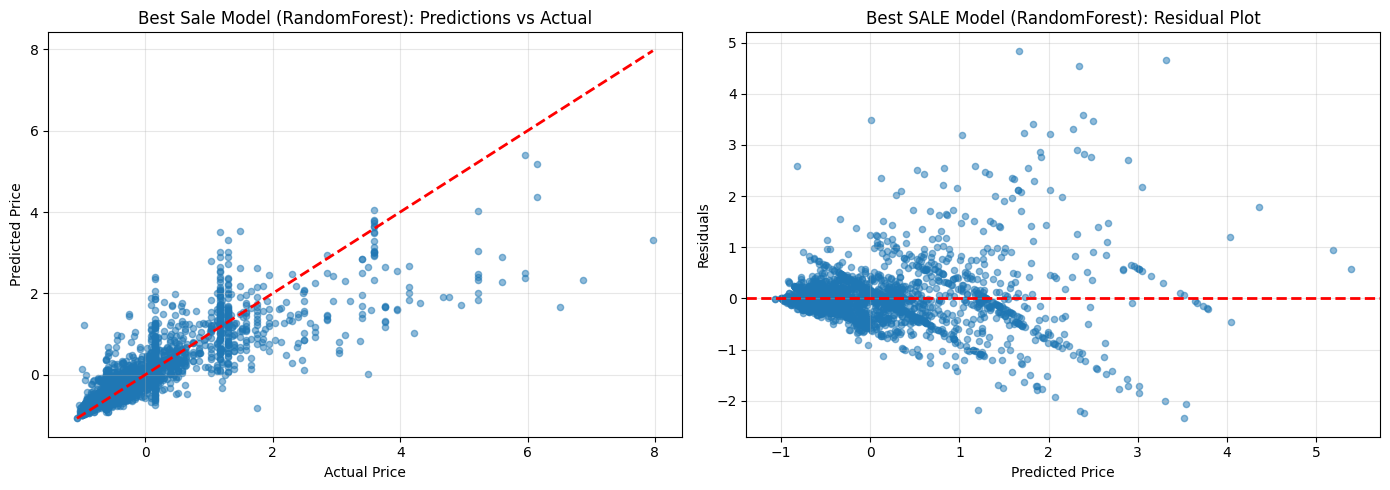

In [35]:
# Visualize predictions vs actual for best model
best_model_name = results_sorted.iloc[0]["Model"]
best_pipeline = trained_pipelines[best_model_name]
best_preds = best_pipeline.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predictions vs Actual
ax1 = axes[0]
ax1.scatter(y_test, best_preds, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel("Actual Price")
ax1.set_ylabel("Predicted Price")
ax1.set_title(f"Best Sale Model ({best_model_name}): Predictions vs Actual")
ax1.grid(True, alpha=0.3)

# Residuals
residuals = y_test - best_preds
ax2 = axes[1]
ax2.scatter(best_preds, residuals, alpha=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel("Predicted Price")
ax2.set_ylabel("Residuals")
ax2.set_title(f"Best SALE Model ({best_model_name}): Residual Plot")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Log Experiments with MLflow

In [24]:
# Set up MLflow experiment
mlflow.set_experiment("real_estate_sale_regression")

print("Logging SALE experiments to MLflow...\n")

# Log each model
for model_name, pipeline in trained_pipelines.items():
    with mlflow.start_run(run_name=model_name):
        # Get predictions
        preds = pipeline.predict(X_test)
        
        # Calculate metrics
        rmse = root_mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # Log parameters
        mlflow.log_param("model", model_name)
        mlflow.log_param("dataset", "sale_processed")
        mlflow.log_param("target_col", target_col)
        mlflow.log_param("n_train", len(X_train))
        mlflow.log_param("n_test", len(X_test))
        mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", 42)
        
        # Log metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        
        # Log model
        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"✓ {model_name} logged to MLflow")

print("\n✓ All SALE models logged successfully!")
print("\nTo view MLflow UI, run: mlflow ui")

Logging SALE experiments to MLflow...

✓ Ridge logged to MLflow
✓ RandomForest logged to MLflow
✓ GradientBoosting logged to MLflow
✓ XGBoost logged to MLflow
✓ LightGBM logged to MLflow

✓ All SALE models logged successfully!

To view MLflow UI, run: mlflow ui
